In [3]:
from IPython.display import Image

# Introduction to the computational graph

Diagrams are courtesy of: http://colah.github.io/posts/2015-08-Backprop/

When we write computer programs, we are used to doing computation in a bunch of imperative statements, like so:

In [11]:
def some_function(a,b):
    c = a+b
    d = b+1
    e = c*d
    return e

Let's evaluate on some random inputs:

In [12]:
print some_function(1,1)
print some_function(1,2)
print some_function(3,4)

4
9
35


This function can also be visualised as a graph:

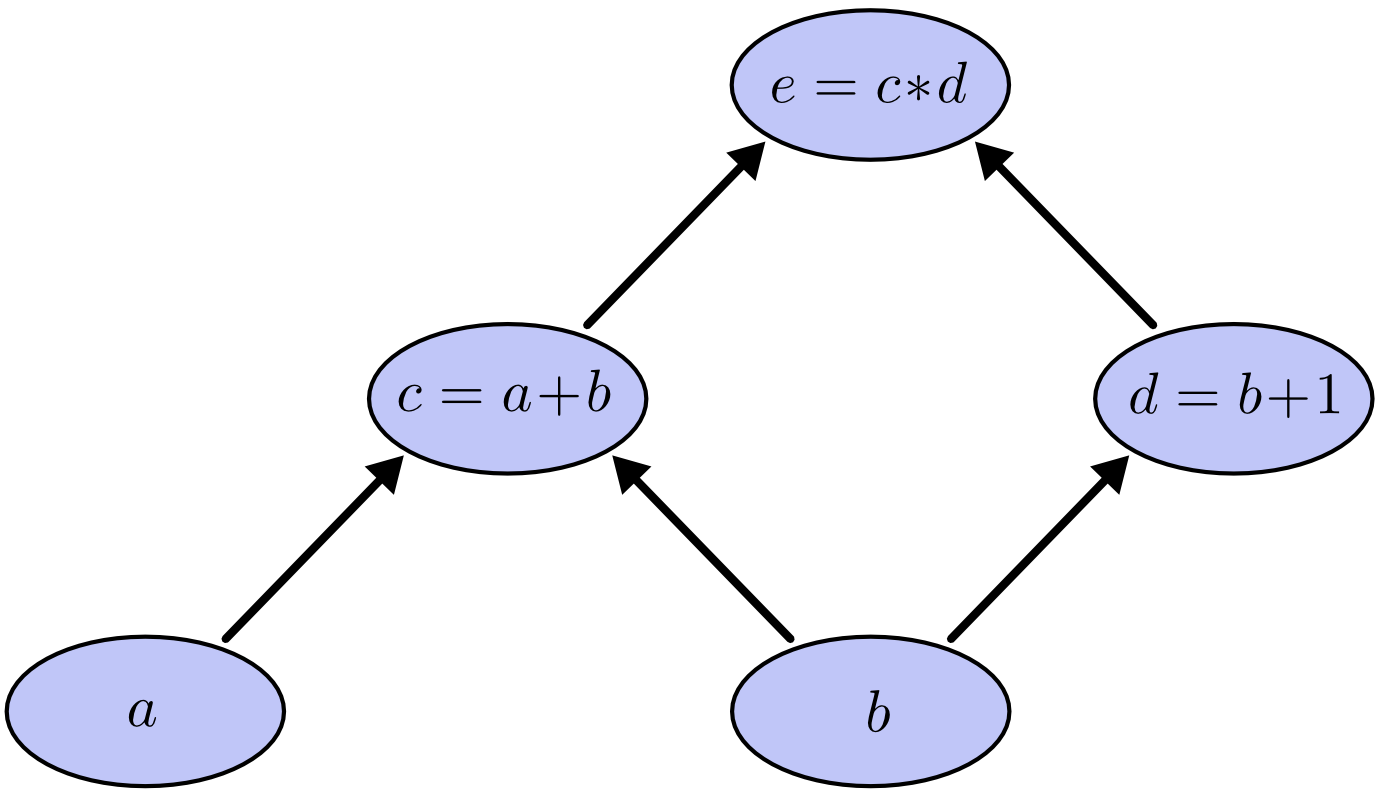

In [5]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-def.png", width=500)

We can also perform the computation of the above function from the bottom-up, which is called a forward pass. Here we will set `a = 2` and `b = 1`

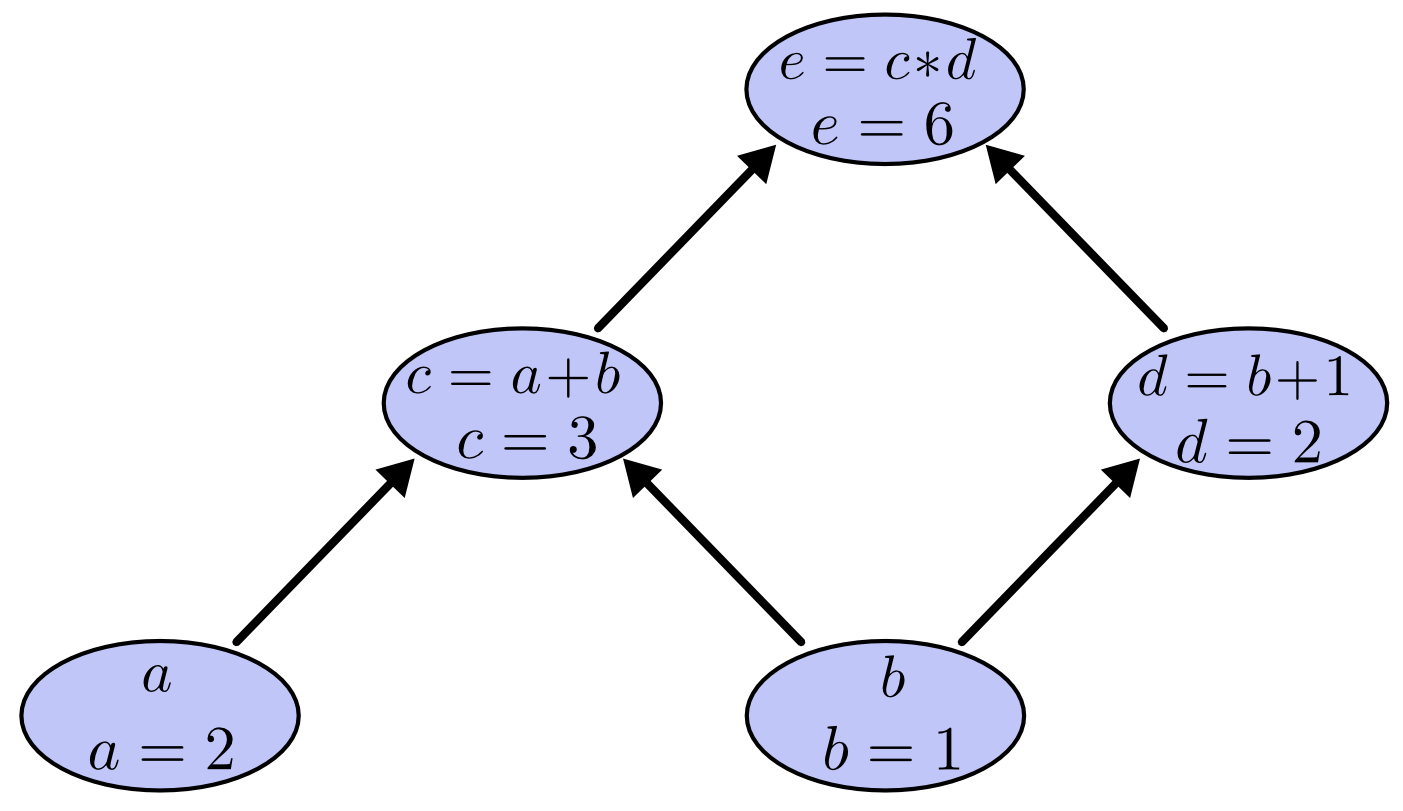

In [9]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png", width=500)

In [13]:
some_function(2,1)

6

In deep learning, we write models that are expressed in these kinds of computational graphs. Ideally, we'd like to write code like we would in Python -- that is, in an imperative style -- but have the resulting representation be some kind of graph we can traverse.

## Why is this representation useful?

We can compute derivatives easily, in a manner that is local. By 'local', we mean, we can traverse the graph the compute derivatives incrementally, without the considering the graph as a whole.

### Calculus refresher

There are two formulas that are useful to remember, the sum rule, product rule, and the chain rule:

$$ \frac{\partial (a+b)}{\partial a} = \frac{\partial a}{\partial a} + \frac{\partial b}{\partial a}$$

$$ \frac{\partial uv}{u} = u \cdot \frac{\partial v}{\partial u} + v \cdot \frac{\partial u}{\partial u}$$

In the example below, at every edge, we can compute the **derivative of the output of that edge, with respect to the input of that edge.**

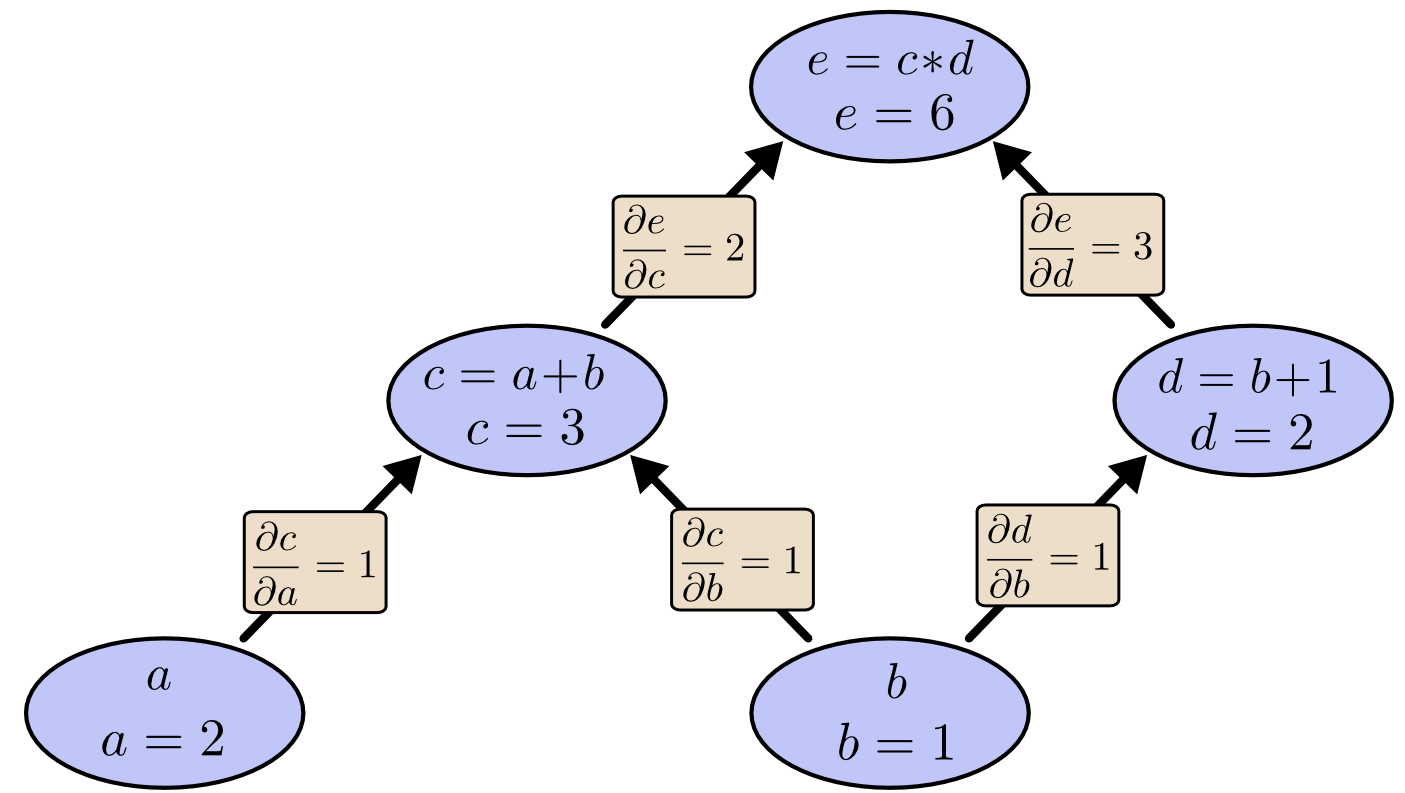

In [18]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png", width=600)

$$ \frac{\partial c}{\partial a} = \frac{\partial (a+b)}{\partial a} = \frac{\partial a}{\partial a} + \frac{\partial b}{\partial a} = 1 + 0 = 1 \ \ \ \ \text{(sum rule)}$$

$$\frac{\partial e}{\partial c} = \frac{\partial cd}{\partial c} = d = 2 \ \ \  \text{(product rule)}$$

What if we wanted to compute the derivative of every expression with respect to the inputs $a$ and $b$?

Currently, the only derivatives we have with respect to the inputs are:
$ \frac{\partial c}{\partial a} $, $ \frac{\partial c}{\partial b}$, and $ \frac{\partial d}{\partial b} $

Let's say we wanted to compute $\frac{\partial e}{\partial b}$. How do we do this? Well, this is where the chain rule comes in! **(Do the diagram on the blackboard)**

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b} = 1 \cdot 3 = 3$$

If you were to apply the chain rule in this fashion, computing the derivative of every node with respect to $a$ and the derivative of every node with respect to $b$, by the time you reached the top of the graph, you would have the derivative of every expression with respect to *all* the inputs. This is called **forward-mode differentiation**.

There is also another form called **reverse-mode differentiation**. In this mode, we don't want the derivative of every expression *with respect to the input* -- we want the derivative of every expression *with respect to the output!*

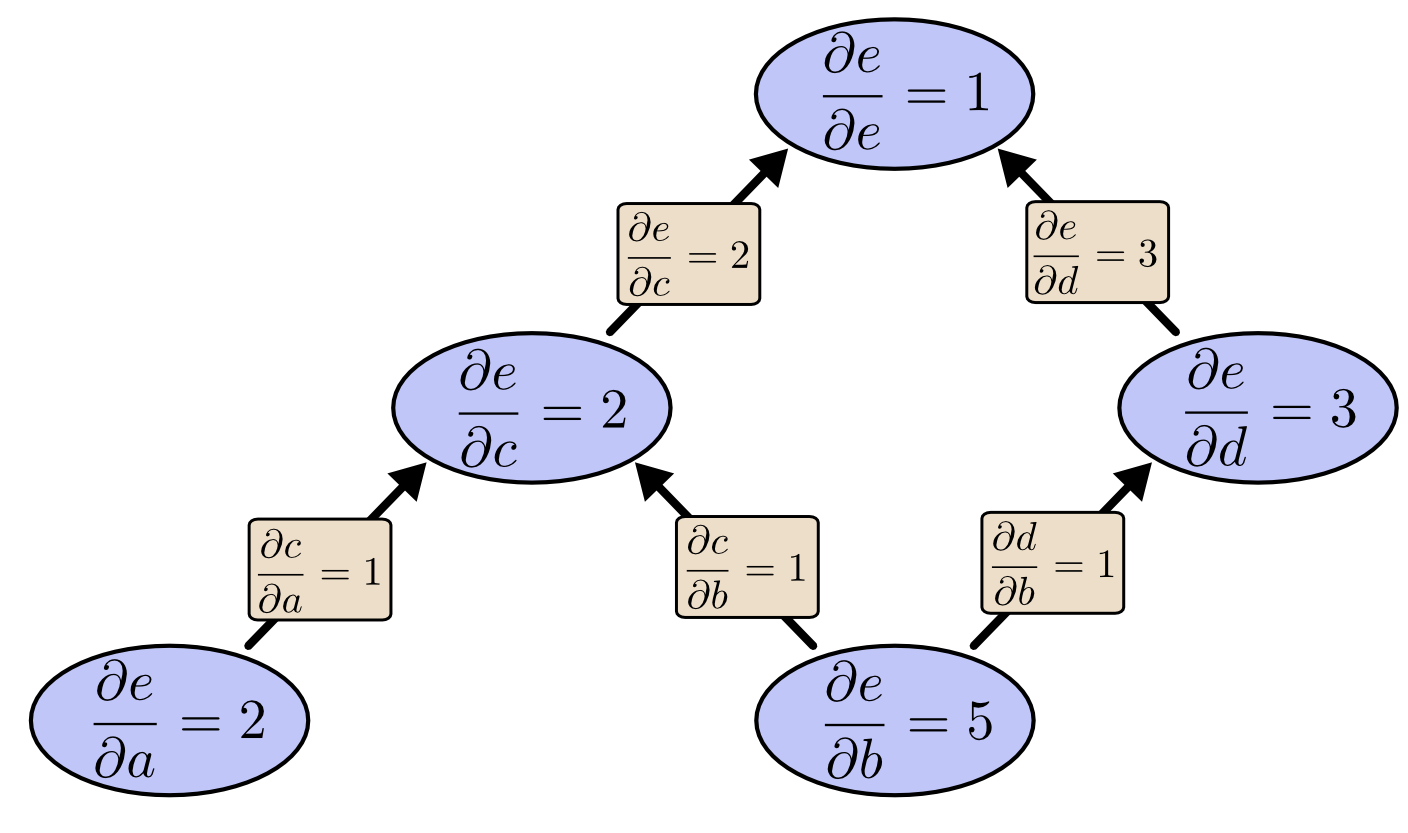

In [19]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-backprop.png", width=600)

Let's do this on the blackboard so we know how these derivatives were computed.

*Note to myself: mark each derivative as 'we are given', 'we can compute', 'we need'*

At the $d$ node, we are given: $\frac{\partial e}{\partial d}$, and we need to compute $\frac{\partial e}{\partial b}$. So the key ingredient we need to compute is $\frac{\partial d}{\partial b}$, such that:

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b} $$

At the $c$ node, we are given: $\frac{\partial e}{\partial c}$, and we need to compute $\frac{\partial e}{\partial b}$. So the key ingredient we need to compute is $\frac{\partial c}{\partial b}$, such that:

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial b} $$

But hold on a second... now, the $b$ node has two of these $\frac{\partial e}{\partial b}$'s coming to it! Well, we just sum these together!

In deep learning, the parameters that we wish to optimise can be seen as 'inputs' to the graph. So if we can easily compute the derivative of an output with respect to all these parameters, we have an efficient way to optimise our network.

## Simple linear regression